In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Sieves

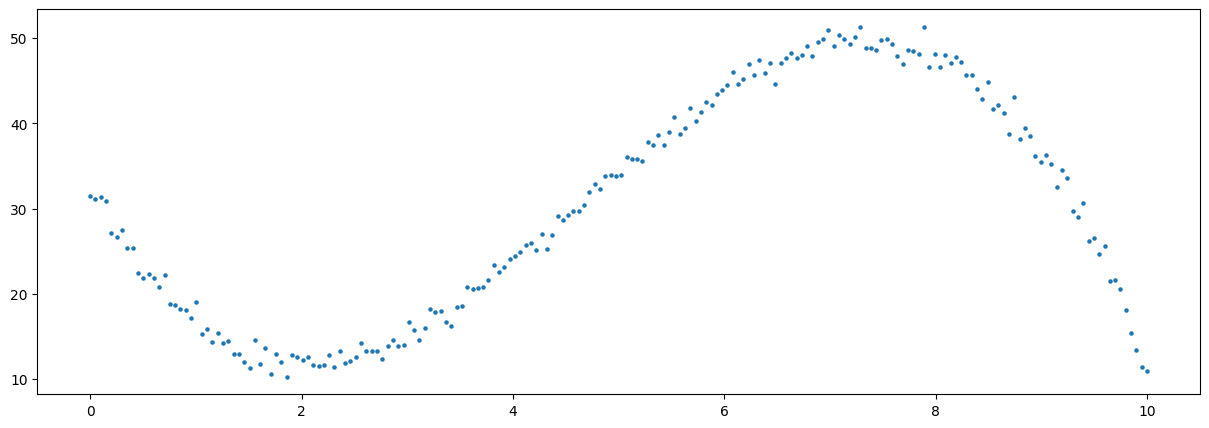

In [12]:
# create some regression curve with trend and noise
n = 200
x = np.linspace(0, 10, n)
y = 2 * x + x**2 - 0.5 * (x - 4) ** 3 + np.random.normal(0, 1, n)

# plot the data
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=5)
plt.show()


### Splines

#### Polynomial Splines

In [ ]:
# # plot splines
# plt.figure(figsize=(5, 2))
# plt.plot(x_grid, design_mat[:, 0], label="glob constant")
# plt.plot(x_grid, design_mat[:, 1], label="glob linear")
# plt.plot(x_grid, design_mat[:, 2], label="glob quadratic")
# plt.plot(x_grid, design_mat[:, 3], label="glob cubic")
# for i in range(4, design_mat.shape[1]):
#     plt.plot(x_grid, design_mat[:, i], label=f"spline {i-3}")
# # plt.legend()
# plt.show()

# # plot each spline * beta
# plt.figure(figsize=(15, 5))
# plt.plot(x_grid, design_mat[:, 0] * beta[0], label="glob constant")
# plt.plot(x_grid, design_mat[:, 1] * beta[1], label="glob linear")
# plt.plot(x_grid, design_mat[:, 2] * beta[2], label="glob quadratic")
# plt.plot(x_grid, design_mat[:, 3] * beta[3], label="glob cubic")
# for i in range(4, design_mat.shape[1]):
#     plt.plot(x_grid, design_mat[:, i] * beta[i], label=f"spline {i-3}")
# plt.legend()
# plt.show()

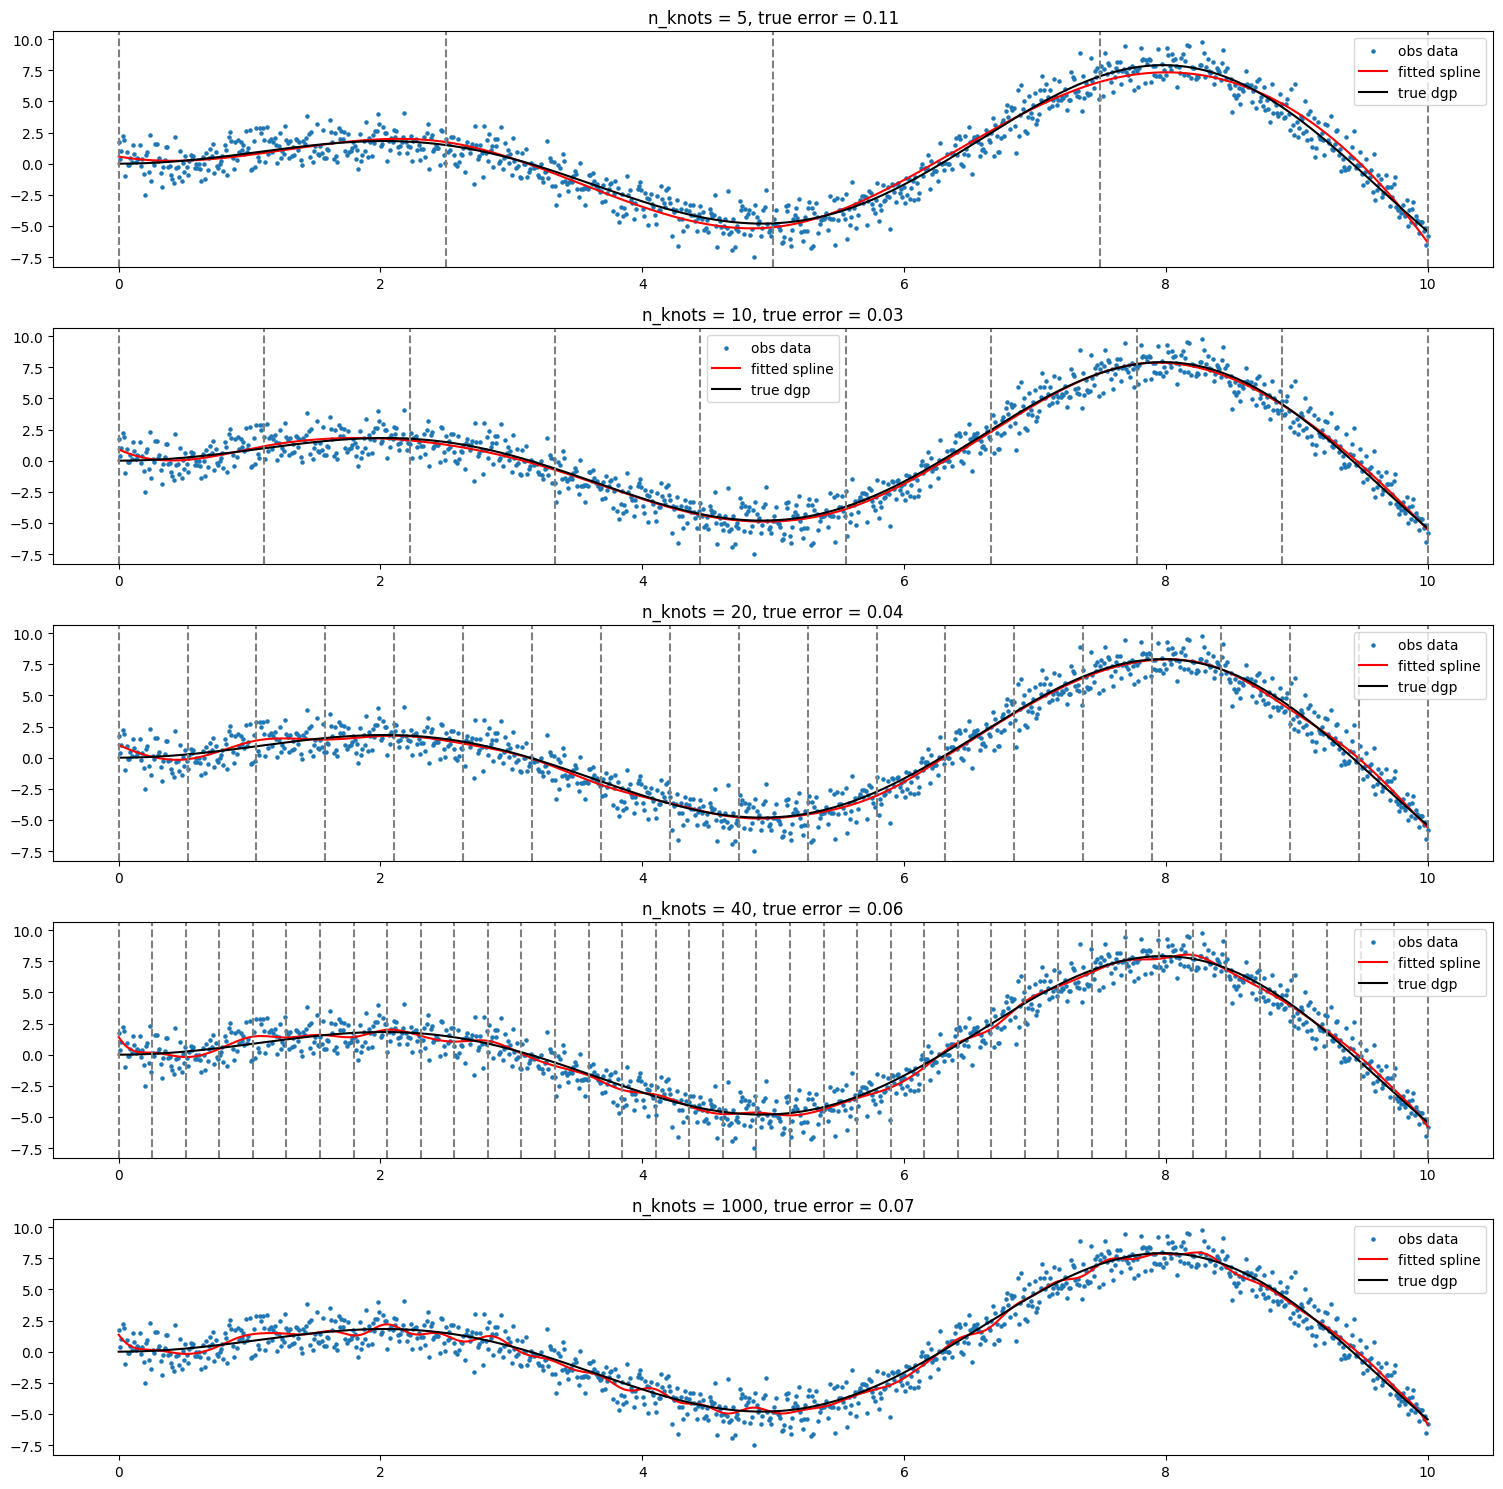

In [102]:
# generate some data based on trend and noise
n = 1000
x = np.linspace(0, 10, n)

y_true = np.sin(x) * 2 * x + x**2 - 0.5 * (x - 4) ** 3
y_true = np.sin(x) * x

np.random.seed(0)
y = y_true + np.random.normal(0, 1, n)
x_grid = np.linspace(0, 10, n)

# plt.figure(figsize=(5, 2))
# plt.scatter(x, y, s=5)

n_knots_arr =  [5, 10, 20, 40, n]
fig, axes = plt.subplots(len(n_knots_arr), 1, figsize=(15, 15))

for idx, n_knots in enumerate(n_knots_arr):

    # define knots
    knots = np.linspace(0, 10, n_knots)
    design_mat = np.zeros((len(x_grid), len(knots) + 4))

    design_mat[:, 0] = 1
    design_mat[:, 1] = x_grid
    design_mat[:, 2] = x_grid**2
    design_mat[:, 3] = x_grid**3

    for knot_idx, knot in enumerate(knots):
        # create the cubic function at that knot point
        local_cubic_spline = np.maximum(0, (x_grid - knot) ** 3)
        # add function points to the design matrix
        design_mat[:, knot_idx + 4] = local_cubic_spline

    # print matrix beautifully
    # print(pd.DataFrame(design_mat))

    # fit the model
    beta = np.linalg.pinv(design_mat.T @ design_mat) @ design_mat.T @ y
    y_hat = design_mat @ beta

    # calc true error to dgp
    true_error = np.mean((y_hat - y_true) ** 2)

    # plot the fitted splines against the data
    # plt.figure(figsize=(15, 5))

    ax = axes[idx]
    ax.scatter(x, y, s=5, label="obs data")
    ax.plot(x, y_hat, color="red", label="fitted spline")
    ax.plot(x, y_true, color="black", label="true dgp")
    if n_knots < 100:
        for knot in knots:
            ax.axvline(knot, color="grey", linestyle="--")
    ax.set_title(f"n_knots = {n_knots}, true error = {true_error:.2f}")
    ax.legend()

plt.tight_layout()
plt.show()

In [141]:
def cubic_splines(x_obs, y_obs, knots):

    """
    Fit a polynomial spline to the given data points.

    Args:
        x_obs: np.array
            The x values of the observed data points
        y_obs: np.array
            The y values of the observed data points
        knots: np.array
            The knot points to fit the spline to

    Returns:
        y_hat: np.array
            The predicted y values of the fitted spline
        beta: np.array
            The fitted coefficients of the spline

    """

    # based on given J knotpoints

    # fit basis functions globally just like fourier term regression
    # make J cubic functions for each knot point
    # along with {1, x, x**2, x**3}
    # and then fit the coefficients using least squares

    design_mat = np.zeros((len(x_obs), len(knots) + 4))

    design_mat[:, 0] = 1
    design_mat[:, 1] = x_obs
    design_mat[:, 2] = x_obs**2
    design_mat[:, 3] = x_obs**3

    for knot_idx, knot in enumerate(knots):
        # create the cubic function at that knot point
        local_cubic_spline = np.maximum(0, (x_obs - knot) ** 3)
        # add function points to the design matrix
        design_mat[:, knot_idx + 4] = local_cubic_spline

    # print matrix beautifully
    # print(pd.DataFrame(design_mat))

    # fit the model using least squared formula
    beta = np.linalg.pinv(design_mat.T @ design_mat) @ design_mat.T @ y_obs
    y_hat = design_mat @ beta
        
    # fit model using existing lin reg    
    # model = LinearRegression()
    # model.fit(design_mat, y_obs)
    # y_hat = model.predict(design_mat)
    # beta = model.coef_

    return y_hat, beta

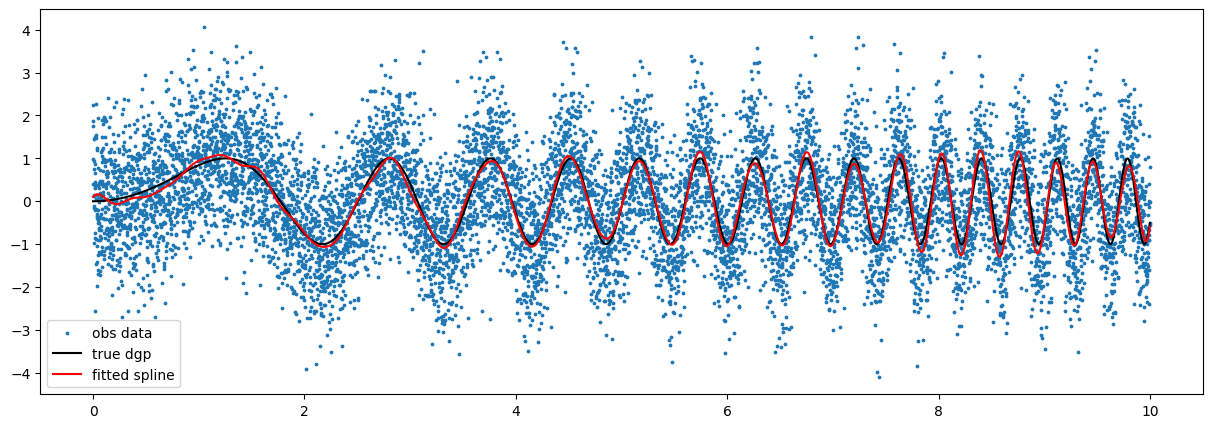

In [144]:
# generate data
n = 10000
x = np.linspace(0, 10, n)
y_true = np.sin(x**2)
np.random.seed(0)
y = y_true + np.random.normal(0, 1, n)

# fit the model
knots = np.linspace(0, 10,400)
y_hat, beta = cubic_splines(x, y, knots)

# plot the fitted splines against the data
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=3, label="obs data")
plt.plot(x, y_true, color="black", label="true dgp")
plt.plot(x, y_hat, color="red", label="fitted spline")
# for knot in knots:
#     plt.axvline(knot, color="grey", linestyle="--")
plt.legend()
plt.show()

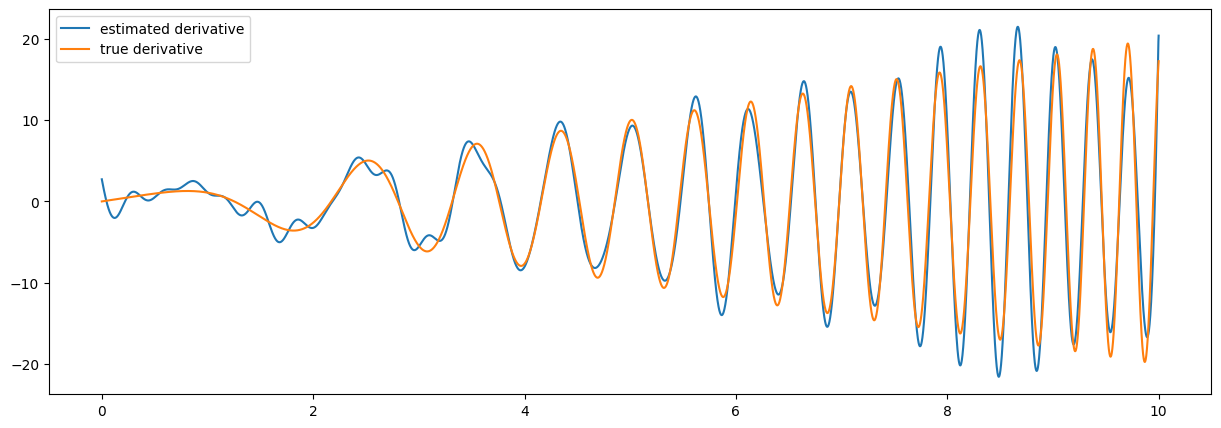

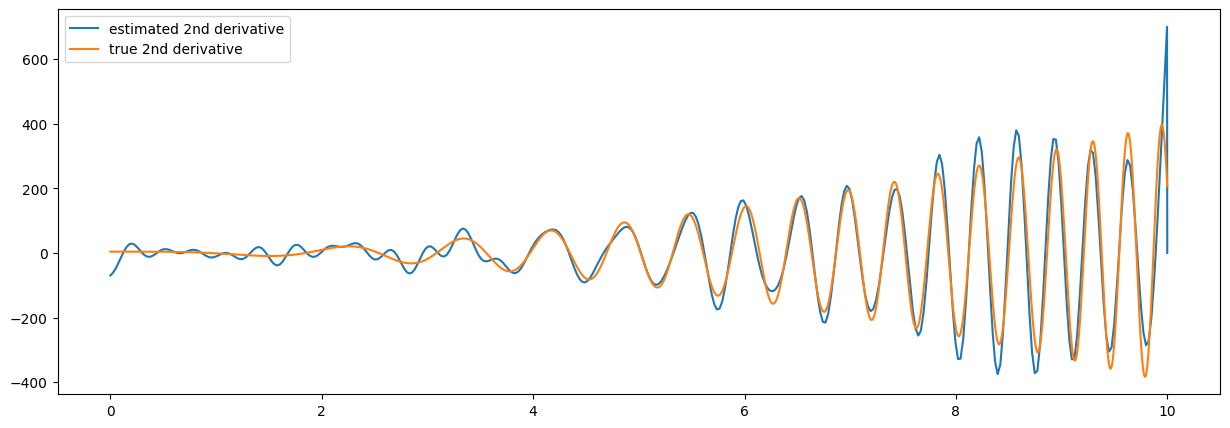

In [145]:
# estimate 1st derivative of y_hat
# using finite difference method
dy_dx = np.diff(y_hat) / np.diff(x)
dy_dx = np.concatenate([dy_dx, [dy_dx[-1]]]) 
# since we took the difference, the length of dy_dx is 1 less than the length of y_hat
# so simply repeat the last element of dy_dx to make it the same length as y_hat

# estimate 2nd derivative of y_hat
# using finite difference method
d2y_dx2 = np.diff(dy_dx) / np.diff(x)
d2y_dx2 = np.concatenate([d2y_dx2, [d2y_dx2[-1]]])

# plot the estimated derivative
plt.figure(figsize=(15, 5))
plt.plot(x, dy_dx, label="estimated derivative")
plt.plot(x, 2 * x * np.cos(x**2), label="true derivative")
plt.legend()
plt.show()

# plot the estimated 2nd derivative
plt.figure(figsize=(15, 5))
plt.plot(x, d2y_dx2, label="estimated 2nd derivative")
plt.plot(x, -4 * x**2 * np.sin(x**2) + 4 * np.cos(x**2), label="true 2nd derivative")
plt.legend()
plt.show()

#### Smoothing Splines

### Marginal Integration

### Backfitting